In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="sGA2DpunzZn52QNW4hQd")
project = rf.workspace("utm-zaimq").project("skin-diseases-bkejc")
version = project.version(3)
dataset = version.download("folder")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.6 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to skin-diseases-3 in folder:: 100%|██████████| 5202/5202 [00:00<00:00, 6087.58it/s]


In [3]:
import torch
from torch import nn, optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [4]:
# Set hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 10
img_size = (224, 224) 

**Hyperparameters. **
I set up some hyperparameters for the model. These are the values that guide how the model learns during training. Here's what I did:
Batch Size: I set batch_size to 32, which means the model will work with 32 data samples at a time before updating its weights. It's like breaking the work into smaller, more manageable chunks.
Learning Rate: I chose a learning_rate of 0.001, which controls how big the adjustments to the model’s parameters are during training. It’s small enough to learn steadily without overshooting.
Number of Epochs: I set num_epochs to 10, so the model will loop through the entire dataset 10 times to make sure it learns well.
Image Size: I resized all the input images to (224, 224) so they’re all the same size and can be processed by the model properly.

In [5]:
def plot_training_history(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Val Loss', marker='o')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Val Accuracy', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



I wrote a function called plot_training_history to visualize the training and validation performance of my model. The goal of this function is to create two side-by-side graphs: one for loss and one for accuracy, helping me understand how the model is learning over time. Here’s what I did:
First, I calculated the range of epochs to use as the x-axis for both plots. Then, I set up a figure with two subplots: one for loss and another for accuracy.
For the loss plot, I added the training loss and validation loss as separate lines, using markers to make the points stand out. I gave the plot a title, labeled the axes as "Epochs" and "Loss," and added a legend to distinguish between the two lines.
Next, for the accuracy plot, I did the same but with training accuracy and validation accuracy. Again, I used markers, added a title, labeled the axes as "Epochs" and "Accuracy," and included a legend.
Finally, I used tight_layout() to make sure the plots didn’t overlap and called show() to display them.
This function provides a clear way to compare training and validation performance over each epoch, making it easier to spot issues like overfitting or underfitting.

In [6]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()  # Set model to training mode
        
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track training loss and accuracy
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_preds / total_preds
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        val_correct_preds = 0
        val_total_preds = 0
        
        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct_preds += (preds == labels).sum().item()
                val_total_preds += labels.size(0)
        
        val_loss = val_running_loss / len(val_loader)
        val_accuracy = val_correct_preds / val_total_preds
        val_loss_history.append(val_loss)
        val_acc_history.append(val_accuracy)
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    return model

I created a train_model function to train and validate a neural network over a specified number of epochs.
During each epoch, I first trained the model using the training data loader. In the training loop, I calculated the loss for each batch, updated the model's parameters using backpropagation, and tracked both the training loss and accuracy.
After training, I evaluated the model using the validation data loader. For validation, I disabled gradient computation to save resources, calculated the loss and accuracy for each batch, and recorded the results.
At the end of each epoch, I printed the training and validation losses and accuracies to monitor the model’s progress. I also stored these metrics in history lists for later visualization. After completing all epochs, I returned the trained model.

In [7]:
# Define transformations for train, val, and test datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.RandomHorizontalFlip(),  # Data augmentation for training
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    ]),
}


In this code, I defined transformations for the training, validation, and test datasets using the PyTorch transforms module. These transformations prepare the data to ensure it is compatible with the model and enhance the model's performance.
For the training dataset, I included several steps: resizing images to 224x224 pixels for uniform input size, applying random horizontal flips as a data augmentation technique to improve generalization, converting images to tensors for computation, and normalizing pixel values using ImageNet statistics.
For the validation and test datasets, I used similar transformations, excluding the augmentation step to maintain consistency in evaluation. By normalizing the data with the same statistics, I ensured that the model performs well on unseen data. This setup is crucial for making the data ready for model training and evaluation.

In [8]:
data_dir = "/kaggle/working/skin-diseases-3"

# Load datasets
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=f"{data_dir}/valid", transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=data_transforms['test'])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In this part of the code, I prepared the datasets and DataLoaders for training, validation, and testing. First, I defined the data_dir variable to specify the directory containing the skin disease images, which are organized into train, valid, and test subdirectories.

Using PyTorch's datasets.ImageFolder, I loaded the images for each dataset. For the training dataset, I applied the transformations defined earlier to include resizing, data augmentation, and normalization. Similarly, I applied appropriate transformations to the validation and test datasets to prepare them for consistent evaluation.

After defining the datasets, I used DataLoader to load the data in batches. The training DataLoader (train_loader) shuffles the data to ensure diverse batches during training, improving the model's generalization. For validation and test DataLoaders (val_loader and test_loader), shuffling is disabled to keep the data order consistent. This step ensures the data is efficiently processed during model training, validation, and testing.

In [9]:
class_names = train_dataset.classes  # List of class names
print("Classes:", class_names)
print("Class-to-Index Mapping:", train_dataset.class_to_idx)

Classes: ['acne', 'atopic', 'bcc']
Class-to-Index Mapping: {'acne': 0, 'atopic': 1, 'bcc': 2}


In this section, I extracted and printed information about the class labels in the training dataset. First, I retrieved the list of class names from train_dataset.classes, which represents the categories of the images. This information is crucial for understanding what types of data the model will work with and ensuring that the dataset is correctly organized.

Next, I printed the class names and their mappings to numerical indices using train_dataset.class_to_idx. This mapping shows how each class is encoded as a number, which is important for the model's training process since it works with numerical labels. By doing this, I confirmed that the dataset was loaded correctly and verified the class structure.

In [10]:
model = models.resnet50(pretrained=True)

# Modify the last layer for your dataset
num_classes = 3  # Number of classes in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


In this part of the code, I set up the ResNet-50 model for my dataset. I started by loading a pre-trained ResNet-50 model, which has been trained on ImageNet. This allows me to leverage the pre-learned features of the model, saving time and computational resources compared to training a model from scratch.

Next, I customized the model to fit my specific dataset with three classes by replacing the last fully connected layer with a new one. The new layer outputs predictions for the three categories, aligning with the size of my dataset's class labels.

After modifying the model, I ensured that it could run efficiently by checking if a GPU was available. If a GPU was present, I moved the model to it; otherwise, the model stayed on the CPU. This step is crucial for optimizing performance during the training and evaluation phases.

In [11]:
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In this section of the code, I set up the components required for training the model. First, I chose a loss function, nn.CrossEntropyLoss(), which is commonly used for multi-class classification tasks. This loss function compares the predicted outputs (class probabilities) with the actual labels and helps the model learn by minimizing the error.

Next, I defined the optimizer as Adam using optim.Adam. The Adam optimizer is popular because it adapts the learning rate for each parameter during training, making it efficient for large datasets and complex models. I set the learning rate to the value specified earlier in the code, which controls how quickly the optimizer updates the model's parameters. This setup is essential for training the model effectively and adjusting its weights to improve accuracy.

In [12]:
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []


In [13]:
trained_model1 = train_model(model, train_loader, val_loader, num_epochs=15)

Epoch 1/15
Train Loss: 0.8249, Train Accuracy: 0.6329
Val Loss: 0.7500, Val Accuracy: 0.7048
Epoch 2/15
Train Loss: 0.6178, Train Accuracy: 0.7415
Val Loss: 0.8127, Val Accuracy: 0.7143
Epoch 3/15
Train Loss: 0.5733, Train Accuracy: 0.7609
Val Loss: 0.6228, Val Accuracy: 0.7905
Epoch 4/15
Train Loss: 0.4984, Train Accuracy: 0.7955
Val Loss: 0.6076, Val Accuracy: 0.7762
Epoch 5/15
Train Loss: 0.4580, Train Accuracy: 0.8160
Val Loss: 0.7517, Val Accuracy: 0.7571
Epoch 6/15
Train Loss: 0.4314, Train Accuracy: 0.8255
Val Loss: 0.5242, Val Accuracy: 0.8143
Epoch 7/15
Train Loss: 0.3918, Train Accuracy: 0.8431
Val Loss: 0.8292, Val Accuracy: 0.7095
Epoch 8/15
Train Loss: 0.4379, Train Accuracy: 0.8158
Val Loss: 0.6552, Val Accuracy: 0.7952
Epoch 9/15
Train Loss: 0.3411, Train Accuracy: 0.8624
Val Loss: 0.7710, Val Accuracy: 0.7524
Epoch 10/15
Train Loss: 0.3287, Train Accuracy: 0.8678
Val Loss: 0.7543, Val Accuracy: 0.7857
Epoch 11/15
Train Loss: 0.3128, Train Accuracy: 0.8776
Val Loss: 0.64

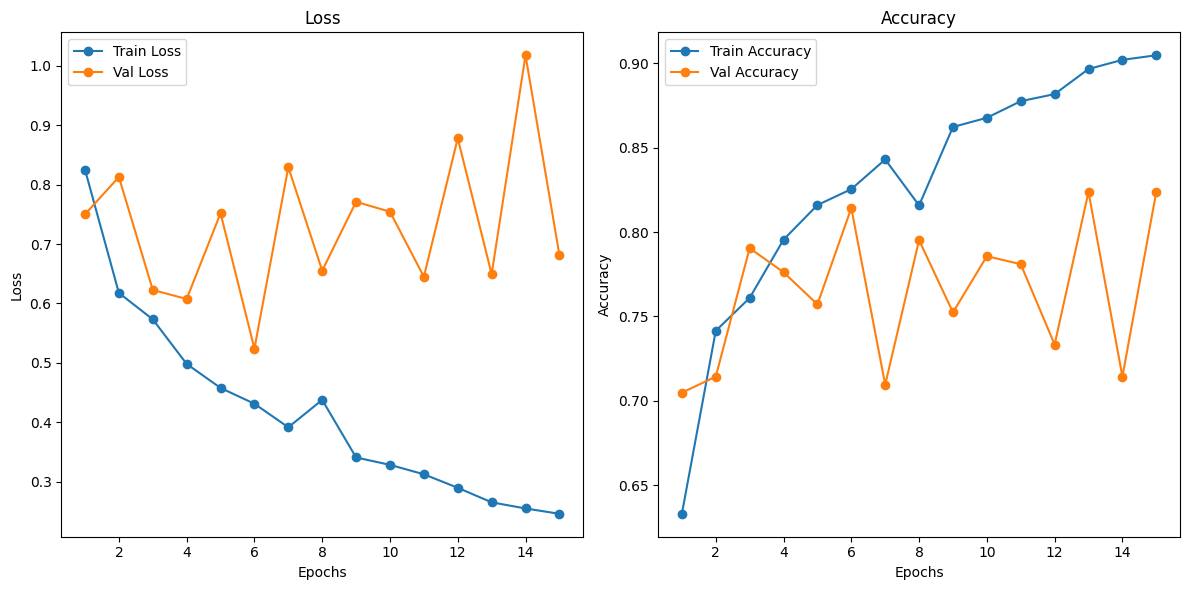

In [14]:
def plot_training_history(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Val Loss', marker='o')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Val Accuracy', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

In this part of the code, I set up the loss function and optimizer for training the model. I used CrossEntropyLoss() for the loss function, which is suitable for multi-class classification tasks, and the Adam optimizer with a specified learning rate to adjust the model's parameters during training.

I then defined a function, plot_training_history, to visualize the training process. This function generates two plots side by side: one for the loss values (both training and validation) and one for the accuracy values. In both plots, I plotted the values against the epochs to track how the model improved over time. I used markers on the curves for clarity, added titles, labels, and legends to make the plots more informative, and made sure the layout was neat using plt.tight_layout().

Finally, I called this function, passing in the historical data for training and validation loss and accuracy, to generate and display the plots, helping me analyze the model's performance visually.

In [15]:
torch.save(model.state_dict(), "resnet50_model.pth")

In this line of code, I saved the trained ResNet50 model's parameters (weights and biases) to a file named "resnet50_model.pth". By using the state_dict() method, I made sure to store only the model's learned parameters, which is a lightweight and efficient way to save a model in PyTorch. This allows me to reload and use the model later without having to retrain it from scratch.